# DATS 2103: Homework #5 - Matteo Larrode


In [94]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
tennis_ex = pd.read_csv("data/tennis.csv")

#relabel its columns
tennis_ex.columns = ['Outlook', 'Temperature', 'Humidity', 'Windy', 'Play']

print(tennis_ex.shape)
print(tennis_ex.head())

(14, 5)
    Outlook Temperature Humidity  Windy Play
0     sunny         hot     high  False   no
1     sunny         hot     high   True   no
2  overcast         hot     high  False  yes
3     rainy        mild     high  False  yes
4     rainy        cool   normal  False  yes


2. 

We need to build a function calculating entropy at a specific node, based on the mathematical formula. As input, the function will take the list of the values taken by the variable of interest in the node.

For example, if the node contains 4 'yes' and 2 'no', the list could be [yes, yes, no, yes, no, yes].

In [55]:
import math

def calc_entropy(Node):
    #size of the node
    size = len(Node)
    #number of occurences: dictionary
    counts = {}
    for label in Node:
        if label in counts:
            counts[label] += 1
        else:
            counts[label] = 1
    #calculate entropy
    entropy = 0
    for n in counts.values():
        pi = n / size
        entropy -= pi * math.log2(pi)
    return entropy
    


Let's test the function with one example from class (Lecture 17).

In [56]:
print(calc_entropy(['yes', 'yes', 'no', 'no', 'no', 'no' , 'no', 'no']))

0.8112781244591328


We get the same result.

3. For each feature, we will now calculate the information gain, based on the entropy function, if it were used for a split.

Information gain is calculated like this: **IG = Entropy(parent) – Average Entropy(children)**

We create a function that takes three arguments: 

- df, which is a pandas DataFrame
- feature, which is the name of the variable that we want to use for splitting the data
- output, which is the name of the output variable, here it will be "Play"

The function then calculates information gain using the `calc_entropy` function created earlier.

In [57]:
def calc_IG(df, feature, output):
    #size of the parent node
    size = len(df)

    #calculate parent entropy & initiate child_entropies
    parent_entropy = calc_entropy(list(df[output]))
    child_entropies = []

    #counts of each value of the feature
    var_counts = df[feature].value_counts()

    #for each value of the feature, calculates entropy of the child node
    for value, count in var_counts.items():
        #subset dataframe to only include instances with that value 
        child_node = df[df[feature] == value]
        #calculate entropy of that node
        child_entropy = calc_entropy(list(child_node[output]))

        #append WEIGHTED child entropy 
        child_entropies.append(child_entropy * count / size)

    #information gain
    info_gain = parent_entropy - sum(child_entropies)
    return info_gain
    


Let's test this function on a class example (Lecture 17):

In [58]:
test_data = {
    'Outlook': ['Sunny', 'Sunny', 'Rainy', 'Sunny'],
    'Temperature': ['Cool', 'Cool', 'Hot', 'Hot'],
    'Humidity': ['Low', 'High', 'Low', 'High'],
    'Play': ['Yes', 'Yes', 'No', 'No']
    }

test_df = pd.DataFrame(test_data)

print(calc_IG(test_df, 'Outlook', "Play"))

0.31127812445913283


We get the same result! 

Now we can calculate all the information gains. 

In [59]:
for feature in tennis_ex.columns:
    if (feature != "Play"):
        print(f"Information gain of splitting by {feature} is: {calc_IG(tennis_ex, feature, 'Play')}")

Information gain of splitting by Outlook is: 0.24674981977443922
Information gain of splitting by Temperature is: 0.02922256565895487
Information gain of splitting by Humidity is: 0.15183550136234159
Information gain of splitting by Windy is: 0.04812703040826949


4. The feature with the highest information gain is "Outlook". Let's split the dataframe based on this feature.

In [60]:
print(set(tennis_ex["Outlook"]))

{'overcast', 'sunny', 'rainy'}


In [61]:
child_df_1 = tennis_ex[tennis_ex["Outlook"] == "overcast"]
child_df_2 = tennis_ex[tennis_ex["Outlook"] == "sunny"]
child_df_3 = tennis_ex[tennis_ex["Outlook"] == "rainy"]

5. Finally, here are some statistics for each child note that resulted from the split.

In [62]:
def summary_stats(df):
    # Get the number of samples
    num_samples = len(df)

    print("Number of samples:", num_samples)

    # Get the distribution of "Yes" and "No" for the Play variable, set as 0 if none
    play_counts = df['Play'].value_counts()
    yes_count = play_counts.get('yes', 0)
    no_count = play_counts.get('no', 0)

    print(f"Distribution of 'yes' for the 'Play' variable: {yes_count} / {num_samples} =", yes_count / num_samples)
    print(f"Distribution of 'no' for the 'Play' variable: {no_count} / {num_samples} =", no_count / num_samples)

    #Get the entropy
    print(f"Entropy of the node: {calc_entropy(list(df['Play']))}")

    return "Success"


In [92]:
print("SUMMARY STATS: OVERCAST")
print(summary_stats(child_df_1))

print("\nSUMMARY STATS: SUNNY")
print(summary_stats(child_df_2))

print("\nSUMMARY STATS: RAINY")
print(summary_stats(child_df_3))

SUMMARY STATS: OVERCAST
Number of samples: 4
Distribution of 'yes' for the 'Play' variable: 4 / 4 = 1.0
Distribution of 'no' for the 'Play' variable: 0 / 4 = 0.0
Entropy of the node: 0.0
Success

SUMMARY STATS: SUNNY
Number of samples: 5
Distribution of 'yes' for the 'Play' variable: 2 / 5 = 0.4
Distribution of 'no' for the 'Play' variable: 3 / 5 = 0.6
Entropy of the node: 0.9709505944546686
Success

SUMMARY STATS: RAINY
Number of samples: 5
Distribution of 'yes' for the 'Play' variable: 3 / 5 = 0.6
Distribution of 'no' for the 'Play' variable: 2 / 5 = 0.4
Entropy of the node: 0.9709505944546686
Success


## Problem 3

In [64]:
#import libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [65]:
#import data 
banknote_df = pd.read_csv("data/data_banknote_authentication.csv", header= None)

banknote_df.columns = ["Feature1", "Feature2", "Feature3", "Feature4", "Target"]

#some exploration:
print('Number of Rows: ', banknote_df.shape[0])
print('Number of Columns: ', banknote_df.shape[1], '\n')
print('Head of Data:\n ', banknote_df.head(), '\n')

Number of Rows:  1372
Number of Columns:  5 

Head of Data:
     Feature1  Feature2  Feature3  Feature4  Target
0   3.62160    8.6661   -2.8073  -0.44699       0
1   4.54590    8.1674   -2.4586  -1.46210       0
2   3.86600   -2.6383    1.9242   0.10645       0
3   3.45660    9.5228   -4.0112  -3.59440       0
4   0.32924   -4.4552    4.5718  -0.98880       0 



Before training a model we need to make sure our data is clean. Let’s check for missing and duplicated values.

In [66]:
print(f"Null Values in Dataset: \n{banknote_df.isnull().sum()}")
print(f"\nDuplicated Values in Dataset: \n{banknote_df.duplicated().sum()}")

Null Values in Dataset: 
Feature1    0
Feature2    0
Feature3    0
Feature4    0
Target      0
dtype: int64

Duplicated Values in Dataset: 
24


 A duplicated datapoint will have double the weight of a normal datapoint, and will therefore affect the resulting decision tree. The decision to remove them or not depends on the goals and context. Indeed, if those 24 duplicates arose naturally, we should keep them if we are interested in maximizing the number of correctly predicted categories. We lack the information on the context of their apparition, so we will assume that they are legitimate, and therefore give us information about the relative occurrences of datapoints. This justifies why I decided to keep those duplicated values in the dataset.

We can now randomly split the banknote data into train (with 70% of samples) and test (with 30% of samples) datasets. It is important to first separate input and output vectors. 

In [67]:
# Separate the target variable & features
y_banknote = banknote_df.Target
X_banknote = banknote_df.drop('Target',axis=1)

# split the dataset into train and test -> random_state for reproducibility
X_train_banknote, X_test_banknote, y_train_banknote, y_test_banknote = train_test_split(X_banknote, y_banknote, test_size=0.3, random_state=5)


Let's have a look at the shape of those new datasets

In [68]:
print("Shape of original dataset :", banknote_df.shape)
print("Shape of input - training set", X_train_banknote.shape)
print("Shape of output - training set", y_train_banknote.shape)
print("Shape of input - testing set", X_test_banknote.shape)
print("Shape of output - testing set", y_test_banknote.shape)

Shape of original dataset : (1372, 5)
Shape of input - training set (960, 4)
Shape of output - training set (960,)
Shape of input - testing set (412, 4)
Shape of output - testing set (412,)


That looks good! Now, let's create a decision tree based on the training data. When building a decision tree, the Gini index and entropy are two common measures used to determine the quality of a split. While both are good measures for decision tree splitting, I chose to build this decision tree using the Gini Index because it is often preferred over entropy when dealing with continuous data.

In [69]:
# creating the classifier object
clf_gini = DecisionTreeClassifier(criterion="gini", max_depth=3, min_samples_leaf=5)

# performing training
clf_gini.fit(X_train_banknote, y_train_banknote)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)

Now that the decision tree classifier has been created and trained, we can use it to make predictions, analyze its quality on the test data, and visualize the corresponding confusion matrix.

In [70]:
# predicton on test using gini
y_pred_gini = clf_gini.predict(X_test_banknote)

In [71]:
# calculate metrics gini model
print("Classification Report: ")
print(classification_report(y_test_banknote,y_pred_gini))
print("Accuracy : ", accuracy_score(y_test_banknote, y_pred_gini) * 100)

Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       222
           1       0.93      0.91      0.92       190

    accuracy                           0.92       412
   macro avg       0.92      0.92      0.92       412
weighted avg       0.92      0.92      0.92       412

Accuracy :  92.47572815533981


The output from the classification_report() function provides a summary of the performance of the classifier on the test dataset. Some important metrics provided above are:

- **Precision** = true positives / (true positives + false positives) -> how many of the samples the model predicted as positive are actually positive.
- **Recall** = true positives / (true positives + false negatives) -> how many of the actual positive samples the model correctly identified as positive
- **F1-score**: combines precision and recall to provide a balanced measure of the classifier's performance
- **Accuracy**: proportion of correctly classified samples (true positives and true negatives) out of the total number of samples

For this first model, the classifier has an accuracy of 92.5%, which means it correctly classified 92.5% of the samples in the test dataset. The precision, recall, and f1-score are all high for both classes, which suggests that the classifier is performing well for both positive and negative samples. Overall, the report indicates that the classifier is performing well on the test dataset.

Let's visualise the confusion matrix to gain more insight:

In [72]:
# confusion matrix for gini model
conf_matrix = confusion_matrix(y_test_banknote, y_pred_gini)
target_values = banknote_df.Target.unique()
conf_matrix_df = pd.DataFrame(conf_matrix, index=target_values, columns=target_values)

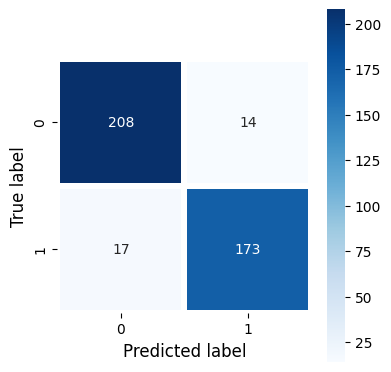

In [73]:
#plot
plt.figure(figsize=(4,4))
hm = sns.heatmap(conf_matrix_df, annot=True, fmt=".0f", linewidths=3, square=True, cmap='Blues', color="#cd1076")
plt.ylabel('True label',fontsize=12)
plt.xlabel('Predicted label',fontsize=12)
plt.tight_layout()
plt.show()

The confusion matrix shows that the model:

- correctly classified 208 instances as negative (true negatives),
- correctly classified 173 instances as positive (true positives),
- incorrectly classified 17 instances as negative, when they were actually positive (false negatives),
- incorrectly classified 14 instances as positive, when they were actually negative (false positives).

Overall, the confusion matrix confirms our assessment that the model has a relatively high accuracy, as most of the instances are correctly classified. However, it also suggests that there is a higher rate of false negatives than false positives, which means that the model may be overly cautious in predicting negative instances.

#### Modifying the predictor

Decision trees are often prone to overfitting. A solution is to utilize the hyper-parameters that control the depth of the tree or limit the expansion of leaf nodes. Let's explore the consequences of doing so on the quality of our classifier. 

The `max_depth` hyper-paramater controls the maximum depth of the tree. If None, nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. It is used to reduce the risk of overfitting because lower values prevent a model from learning relations which might be highly specific to the particular sample. 

Let's try to increase it:


Accuracy :  97.33009708737865


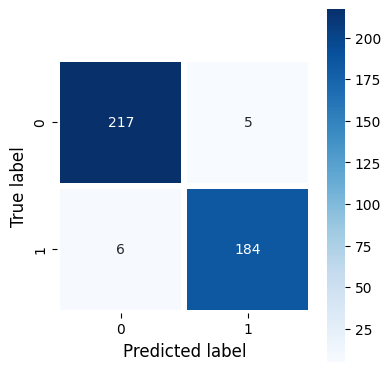

In [74]:
# creating the classifier object
clf_gini2 = DecisionTreeClassifier(criterion="gini", max_depth=10, min_samples_leaf=5)
# performing training
clf_gini2.fit(X_train_banknote, y_train_banknote)
#prediction
y_pred_gini2 = clf_gini2.predict(X_test_banknote)

#accuracy
print("Accuracy : ", accuracy_score(y_test_banknote, y_pred_gini2) * 100)

#confusion matrix
conf_matrix2 = confusion_matrix(y_test_banknote, y_pred_gini2)
conf_matrix_df2 = pd.DataFrame(conf_matrix2, index=target_values, columns=target_values)

#plot
plt.figure(figsize=(4,4))
hm = sns.heatmap(conf_matrix_df2, annot=True, fmt=".0f", linewidths=3, square=True, cmap='Blues', color="#cd1076")
plt.ylabel('True label',fontsize=12)
plt.xlabel('Predicted label',fontsize=12)
plt.tight_layout()
plt.show()

Increasing the maximum depth from 3 to 10 has increased the accuracy of the model from 92.5% to 97.3%. This suggests that the first model was too simple, leading to underfitting. This new, more complex model, is able to capture more accurately the relationship between the input and output variables.

Let's try to further increase the maximum depth.

Accuracy :  97.0873786407767


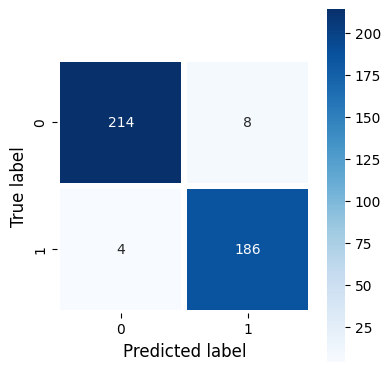

In [75]:
# creating the classifier object
clf_gini3 = DecisionTreeClassifier(criterion="gini", max_depth=500, min_samples_leaf=1)
# performing training
clf_gini3.fit(X_train_banknote, y_train_banknote)
#prediction
y_pred_gini3 = clf_gini3.predict(X_test_banknote)

#accuracy
print("Accuracy : ", accuracy_score(y_test_banknote, y_pred_gini3) * 100)

#confusion matrix
conf_matrix3 = confusion_matrix(y_test_banknote, y_pred_gini3)
conf_matrix_df3 = pd.DataFrame(conf_matrix3, index=target_values, columns=target_values)

#plot
plt.figure(figsize=(4,4))
hm = sns.heatmap(conf_matrix_df3, annot=True, fmt=".0f", linewidths=3, square=True, cmap='Blues', color="#cd1076")
plt.ylabel('True label',fontsize=12)
plt.xlabel('Predicted label',fontsize=12)
plt.tight_layout()
plt.show()

Increasing the maximum depth of the tree to 1,000 led to a decrease in the accuracy from the previous model. This has occured because the model contains too much complexity, resulting in a higher error rate on test data.

The `min_samples_leaf` hyper-paramater controls the minimum number of samples (or observations) required in a leaf. Setting a higher `min_samples_leaf` value ensures that each leaf in the tree has a minimum number of samples, which helps to prevent overfitting by restricting the complexity of the tree. This can improve the model's ability to generalize to new data.

However, setting `min_samples_leaf` too high can cause the model to underfit the data, leading to poor performance on both the training and testing data. Here is an example of what would happen with a very high `min_samples_leaf`, setting a maximum tree depth of 10 like in the second model:

Accuracy :  91.74757281553399


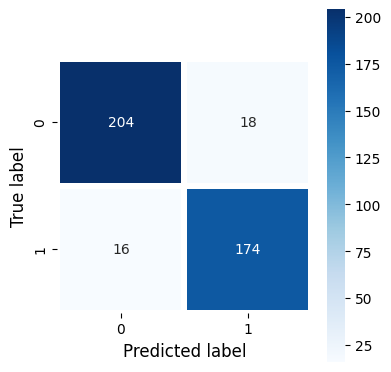

In [76]:
# creating the classifier object
clf_gini4 = DecisionTreeClassifier(criterion="gini", max_depth=10, min_samples_leaf=30)
# performing training
clf_gini4.fit(X_train_banknote, y_train_banknote)
#prediction
y_pred_gini4 = clf_gini4.predict(X_test_banknote)

#accuracy
print("Accuracy : ", accuracy_score(y_test_banknote, y_pred_gini4) * 100)

#confusion matrix
conf_matrix4 = confusion_matrix(y_test_banknote, y_pred_gini4)
conf_matrix_df4 = pd.DataFrame(conf_matrix4, index=target_values, columns=target_values)

#plot
plt.figure(figsize=(4,4))
hm = sns.heatmap(conf_matrix_df4, annot=True, fmt=".0f", linewidths=3, square=True, cmap='Blues', color="#cd1076")
plt.ylabel('True label',fontsize=12)
plt.xlabel('Predicted label',fontsize=12)
plt.tight_layout()
plt.show()

Keeping the maximum depth constant, setting a much higher minimum number of samples (or observations) required in a leaf led to a sharp decrease in the accuracy and overall performance of the model. 

All these examples illustrate the challenge and importance of adjusting hyper-parameters correctly to strike the best balance possible between overfitting and underfitting. Every choice should be justified, and made with transparency. 

## Problem 4

In [77]:
#import libraries
from sklearn.ensemble import RandomForestClassifier

In [78]:
#import data
titanic_df = pd.read_csv("data/titanic_data.csv")

#some exploration:
print('Number of Rows: ', titanic_df.shape[0])
print('Number of Columns: ', titanic_df.shape[1], '\n')
print('Head of Data:\n ')
titanic_df.head()

Number of Rows:  891
Number of Columns:  12 

Head of Data:
 


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We can already drop some variables, such as passenger id, name, ticket, that should not be used as input because there is no logical connection between them and the chances of survival of the passenger. 

In [79]:
titanic_df = titanic_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'],axis=1)

Before starting to train a model, we need to make sure the data is clean. As we have done in Problem 3., let’s check for missing values.

In [80]:
print(f"Null Values in Dataset \n{titanic_df.isnull().sum()}")

Null Values in Dataset 
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


We can easily fill `embarked` with the most common port of embark.

In [81]:
print(f"Number of embarkations per port \n{titanic_df['Embarked'].value_counts()}")

#most common port is Southampton
titanic_df['Embarked'] = titanic_df['Embarked'].fillna(value='S')

Number of embarkations per port 
S    644
C    168
Q     77
Name: Embarked, dtype: int64


Filling age is slightly more tricky. One common approach, discussed in depth in this [Kaggle article](https://www.kaggle.com/code/allohvk/titanic-missing-age-imputation-tutorial-advanced), is to fill every missing age with the average age for the title (Miss, Mr, Mrs, Master, Dr) of the passenger. Unfortunately, the `Title` variable is not included in our dataset. 

Random forests do not handle missing values in predictors; no clear solution can be found to impute the missing values, so I will have to drop the missing values at the risk of losing information, especially given the relatively small size of the sample. 

In [82]:
#drop NAs
titanic_df = titanic_df.dropna()

print(titanic_df.shape)


(714, 8)


Finally, we need to map categorical variables - Sex and Embarked - into numbers. This is easy to do in Pandas using map() method. 

In [83]:
categories = {"female": 1, "male": 0}
titanic_df['Sex']= titanic_df['Sex'].map(categories)

categories = {"S": 1, "C": 2, "Q": 3}
titanic_df['Embarked']= titanic_df['Embarked'].map(categories)

titanic_df.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,1
1,1,1,1,38.0,1,0,71.2833,2
2,1,3,1,26.0,0,0,7.9250,1
3,1,1,1,35.0,1,0,53.1000,1
4,0,3,0,35.0,0,0,8.0500,1


Our data pre-processing is done! We can now split the Titanic data into train (with 70% of samples) and test (with 30% of samples) datasets.

In [84]:
# Separate the target variable & features
y_titanic = titanic_df.Survived
X_titanic = titanic_df.drop(['Survived'],axis=1)


# split the dataset into train and test
X_train_titanic, X_test_titanic, y_train_titanic, y_test_titanic = train_test_split(X_titanic, y_titanic, test_size=0.3, random_state=100)

Let's have a look at the shape of those new datasets

In [85]:
print("Shape of original dataset :", titanic_df.shape)
print("Shape of input - training set", X_train_titanic.shape)
print("Shape of output - training set", y_train_titanic.shape)
print("Shape of input - testing set", X_test_titanic.shape)
print("Shape of output - testing set", y_test_titanic.shape)

Shape of original dataset : (714, 8)
Shape of input - training set (499, 7)
Shape of output - training set (499,)
Shape of input - testing set (215, 7)
Shape of output - testing set (215,)


That looks good. We can now create a Random Forest with 100 trees, and train it on the train data.

In [86]:
#perform training with random forest with all columns
# specify random forest classifier
forest_clf = RandomForestClassifier(n_estimators=100)

# perform training
forest_clf.fit(X_train_titanic, y_train_titanic)

RandomForestClassifier()

Let's use this model to predict passenger survival in the testing dataset. 

Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       137
           1       0.69      0.73      0.71        78

    accuracy                           0.78       215
   macro avg       0.76      0.77      0.77       215
weighted avg       0.78      0.78      0.78       215

Accuracy :  78.13953488372093


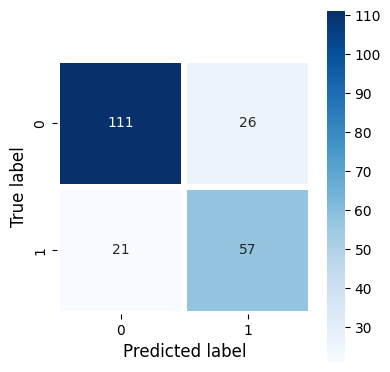

In [87]:
#prediction
y_pred_titanic = forest_clf.predict(X_test_titanic)

#classification report
print("Classification Report: ")
print(classification_report(y_test_titanic,y_pred_titanic))

#accuracy
print("Accuracy : ", accuracy_score(y_test_titanic, y_pred_titanic) * 100)

#confusion matrix
conf_matrix_titanic = confusion_matrix(y_test_titanic, y_pred_titanic)
conf_matrix_df_titanic = pd.DataFrame(conf_matrix_titanic, index=target_values, columns=target_values)

#plot
plt.figure(figsize=(4,4))
hm = sns.heatmap(conf_matrix_df_titanic, annot=True, fmt=".0f", linewidths=3, square=True, cmap='Blues', color="#cd1076")
plt.ylabel('True label',fontsize=12)
plt.xlabel('Predicted label',fontsize=12)
plt.tight_layout()
plt.show()


The model has moderate precision, recall, and F1-score for non-survivors (0.84, 0.81, and 0.83, respectively) and lower precision, recall, and F1-score for survivors (0.69, 0.73, and 0.71, respectively), indicating relatively accurate but not optimal classification performance. The model is better identifying dead people over survivors; this might be due to the fact that there are most examples of them. The overall accuracy of the model is 78.1%, indicating that it correctly predicted the class labels for 78.1% of the instances in the testing sample. 


### Importance of the features

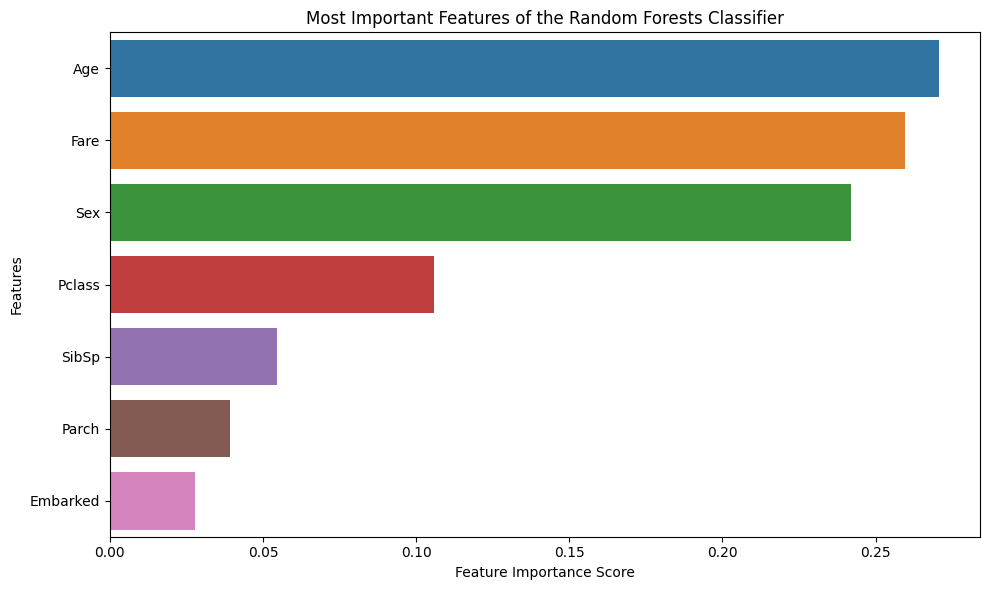

In [88]:
#get Series of feature importances
feat_imp = pd.Series(forest_clf.feature_importances_, index=X_train_titanic.columns).sort_values(ascending=False)

#bar plot
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp, y=feat_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Most Important Features of the Random Forests Classifier")
plt.tight_layout()